![QuantConnect Logo](https://cdn.quantconnect.com/web/i/icon.png)
<hr>

In [ ]:
from AlgorithmImports import *
import numpy as np
import pandas as pd

qb = QuantBook()

spy = qb.add_equity("SPY", Resolution.DAILY)
spy.set_data_normalization_mode(DataNormalizationMode.RAW)

start_date = datetime(2023, 1, 1)
end_date = datetime(2024, 1, 1)

history = qb.history(spy.symbol, start_date, end_date, Resolution.DAILY)

opens = history['open'].droplevel(0)
highs = history['high'].droplevel(0)
lows = history['low'].droplevel(0)
closes = history['close'].droplevel(0)
volumes = history['volume'].droplevel(0)

for s in [opens, highs, lows, closes, volumes]:
    s.index = pd.to_datetime(s.index).normalize()

Data: 250 days


In [ ]:
def compute_rsi(closes, period=14):
    delta = closes.diff()
    gain = delta.where(delta > 0, 0).rolling(period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))


def compute_bollinger_pctb(closes, period=20, std_dev=2):
    ma = closes.rolling(period).mean()
    std = closes.rolling(period).std()
    upper = ma + std_dev * std
    lower = ma - std_dev * std
    return (closes - lower) / (upper - lower)


def compute_atr(highs, lows, closes, period=14):
    tr1 = highs - lows
    tr2 = abs(highs - closes.shift(1))
    tr3 = abs(lows - closes.shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = tr.rolling(period).mean()
    return atr / closes  


def compute_volume_ratio(volumes, period=20):
    return volumes / volumes.rolling(period).mean()


def compute_vwap_deviation(closes, highs, lows, volumes, period=20):
    typical_price = (highs + lows + closes) / 3
    vwap = (typical_price * volumes).rolling(period).sum() / volumes.rolling(period).sum()
    return (closes - vwap) / closes  


rsi = compute_rsi(closes)
bb_pctb = compute_bollinger_pctb(closes)
atr = compute_atr(highs, lows, closes)
volume_ratio = compute_volume_ratio(volumes)
vwap_dev = compute_vwap_deviation(closes, highs, lows, volumes)

print("TECHNICAL INDICATORS")
print("=" * 50)
print(f"RSI:          {rsi.iloc[-1]:.1f} (latest)")
print(f"Bollinger %B: {bb_pctb.iloc[-1]:.3f}")
print(f"ATR:          {atr.iloc[-1]:.4f} ({atr.iloc[-1]*100:.2f}%)")
print(f"Volume Ratio: {volume_ratio.iloc[-1]:.2f}x")
print(f"VWAP Dev:     {vwap_dev.iloc[-1]*100:.2f}%")

TECHNICAL INDICATORS
RSI:          70.8 (latest)
Bollinger %B: 0.756
ATR:          0.0081 (0.81%)
Volume Ratio: 1.39x
VWAP Dev:     1.69%


In [ ]:
spy_option = qb.add_option("SPY", Resolution.DAILY)
spy_option.set_filter(lambda u: u.include_weeklys().strikes(-10, 10).expiration(7, 60))

option_history = qb.option_history(spy.symbol, start_date, end_date, Resolution.DAILY)
option_df = option_history.get_all_data().reset_index()

option_df['time'] = pd.to_datetime(option_df['time'])
option_df['trade_date'] = option_df['time'].dt.normalize()
option_df['expiry'] = pd.to_datetime(option_df['expiry'])
option_df['strike'] = pd.to_numeric(option_df['strike'], errors='coerce')
option_df['mid_price'] = (option_df['bidclose'] + option_df['askclose']) / 2
option_df['DTE'] = (option_df['expiry'] - option_df['trade_date']).dt.days

print(f"Options data: {len(option_df)} contracts")

Options data: 346382 contracts


In [ ]:
from scipy.stats import norm
from scipy.optimize import brentq

def black_scholes_price(S, K, T, r, sigma, option_type='call'):
    if T <= 0 or sigma <= 0:
        return 0.0
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)


def implied_volatility(price, S, K, T, r, option_type='call'):
    if T <= 0 or price <= 0:
        return np.nan
    try:
        return brentq(lambda s: black_scholes_price(S, K, T, r, s, option_type) - price, 0.01, 3.0)
    except:
        return np.nan


def compute_options_features(option_df, underlying_prices, r=0.05):    
    results = {'put_call_ratio': {}, 'iv_skew': {}, 'term_slope': {}}
    
    df = option_df.copy()
    df['is_call'] = df['type'].astype(str).str.contains('Call', case=False)
    
    option_dates = set(df['trade_date'].unique())
    underlying_dates = set(underlying_prices.index)
    common_dates = sorted(option_dates & underlying_dates)
    
    for date in common_dates:
        spot = underlying_prices.loc[date]
        day_opts = df[df['trade_date'] == date].copy()
        
        day_opts['moneyness'] = (day_opts['strike'] - spot) / spot
        day_opts['T'] = day_opts['DTE'] / 365.0
        
        valid = day_opts[
            (day_opts['bidclose'] > 0.05) & 
            (day_opts['DTE'] >= 7) & 
            (day_opts['DTE'] <= 45)
        ].copy()
        
        if len(valid) < 10:
            continue
        
        calls = valid[valid['is_call']]
        puts = valid[~valid['is_call']]
        
        call_vol = calls['volume'].sum()
        put_vol = puts['volume'].sum()
        
        if call_vol > 0:
            results['put_call_ratio'][date] = put_vol / call_vol
        
        # --- IV Skew (OTM put IV - OTM call IV) ---
        otm_puts = valid[(~valid['is_call']) & (valid['moneyness'] > -0.05) & (valid['moneyness'] < -0.02)]
        otm_calls = valid[(valid['is_call']) & (valid['moneyness'] > 0.02) & (valid['moneyness'] < 0.05)]
        
        put_ivs = []
        for _, row in otm_puts.iterrows():
            iv = implied_volatility(row['mid_price'], spot, row['strike'], row['T'], r, 'put')
            if not np.isnan(iv) and 0.05 < iv < 1.0:
                put_ivs.append(iv)
        
        call_ivs = []
        for _, row in otm_calls.iterrows():
            iv = implied_volatility(row['mid_price'], spot, row['strike'], row['T'], r, 'call')
            if not np.isnan(iv) and 0.05 < iv < 1.0:
                call_ivs.append(iv)
        
        if put_ivs and call_ivs:
            results['iv_skew'][date] = np.median(put_ivs) - np.median(call_ivs)
        
        # --- Term Structure Slope (long IV - short IV) ---
        short_term = valid[(valid['DTE'] >= 7) & (valid['DTE'] <= 14) & (abs(valid['moneyness']) < 0.02)]
        long_term = valid[(valid['DTE'] >= 25) & (valid['DTE'] <= 40) & (abs(valid['moneyness']) < 0.02)]
        
        short_ivs = []
        for _, row in short_term.iterrows():
            opt_type = 'call' if row['is_call'] else 'put'
            iv = implied_volatility(row['mid_price'], spot, row['strike'], row['T'], r, opt_type)
            if not np.isnan(iv) and 0.05 < iv < 1.0:
                short_ivs.append(iv)
        
        long_ivs = []
        for _, row in long_term.iterrows():
            opt_type = 'call' if row['is_call'] else 'put'
            iv = implied_volatility(row['mid_price'], spot, row['strike'], row['T'], r, opt_type)
            if not np.isnan(iv) and 0.05 < iv < 1.0:
                long_ivs.append(iv)
        
        if short_ivs and long_ivs:
            results['term_slope'][date] = np.median(long_ivs) - np.median(short_ivs)
    
    return {
        'put_call_ratio': pd.Series(results['put_call_ratio']),
        'iv_skew': pd.Series(results['iv_skew']),
        'term_slope': pd.Series(results['term_slope'])
    }


print("Computing options features...")
opt_features = compute_options_features(option_df, closes)

print("\nOPTIONS FEATURES")
print("=" * 50)
print(f"Put/Call Ratio: {len(opt_features['put_call_ratio'])} days, avg={opt_features['put_call_ratio'].mean():.2f}")
print(f"IV Skew:        {len(opt_features['iv_skew'])} days, avg={opt_features['iv_skew'].mean()*100:.2f}%")
print(f"Term Slope:     {len(opt_features['term_slope'])} days, avg={opt_features['term_slope'].mean()*100:.2f}%")

Computing options features...

OPTIONS FEATURES
Put/Call Ratio: 250 days, avg=1.44
IV Skew:        241 days, avg=5.21%
Term Slope:     250 days, avg=0.60%


In [ ]:
def compute_all_technical_features(opens, highs, lows, closes, volumes, option_df=None):
    """Compute all technical and options features."""
    
    features = pd.DataFrame(index=closes.index)
    
    # Technical indicators
    features['rsi'] = compute_rsi(closes)
    features['bb_pctb'] = compute_bollinger_pctb(closes)
    features['atr'] = compute_atr(highs, lows, closes)
    features['volume_ratio'] = compute_volume_ratio(volumes)
    features['vwap_dev'] = compute_vwap_deviation(closes, highs, lows, volumes)
    
    # Options features (if available)
    if option_df is not None:
        opt_feat = compute_options_features(option_df, closes)
        features['put_call_ratio'] = opt_feat['put_call_ratio']
        features['iv_skew'] = opt_feat['iv_skew']
        features['term_slope'] = opt_features['term_slope']
    
    return features


all_features = compute_all_technical_features(opens, highs, lows, closes, volumes, option_df)

print("ALL FEATURES SUMMARY")
print("=" * 50)
print(all_features.describe().round(4))

ALL FEATURES SUMMARY
            rsi   bb_pctb       atr  volume_ratio  vwap_dev  put_call_ratio  \
count  237.0000  231.0000  237.0000      231.0000  231.0000        250.0000   
mean    57.1036    0.6015    0.0114        1.0060    0.0080          1.4426   
std     17.5266    0.3187    0.0028        0.2419    0.0204          0.3470   
min     18.8560   -0.1490    0.0065        0.3661   -0.0394          0.6838   
25%     43.2856    0.3639    0.0092        0.8464   -0.0056          1.1940   
50%     58.7225    0.6894    0.0107        0.9733    0.0112          1.4328   
75%     70.3263    0.8449    0.0135        1.1492    0.0225          1.6628   
max     91.8873    1.2100    0.0197        1.9914    0.0501          2.4214   

        iv_skew  term_slope  
count  241.0000    250.0000  
mean     0.0521      0.0060  
std      0.0126      0.0142  
min      0.0293     -0.0458  
25%      0.0439     -0.0024  
50%      0.0508      0.0074  
75%      0.0593      0.0158  
max      0.1014      0.0342

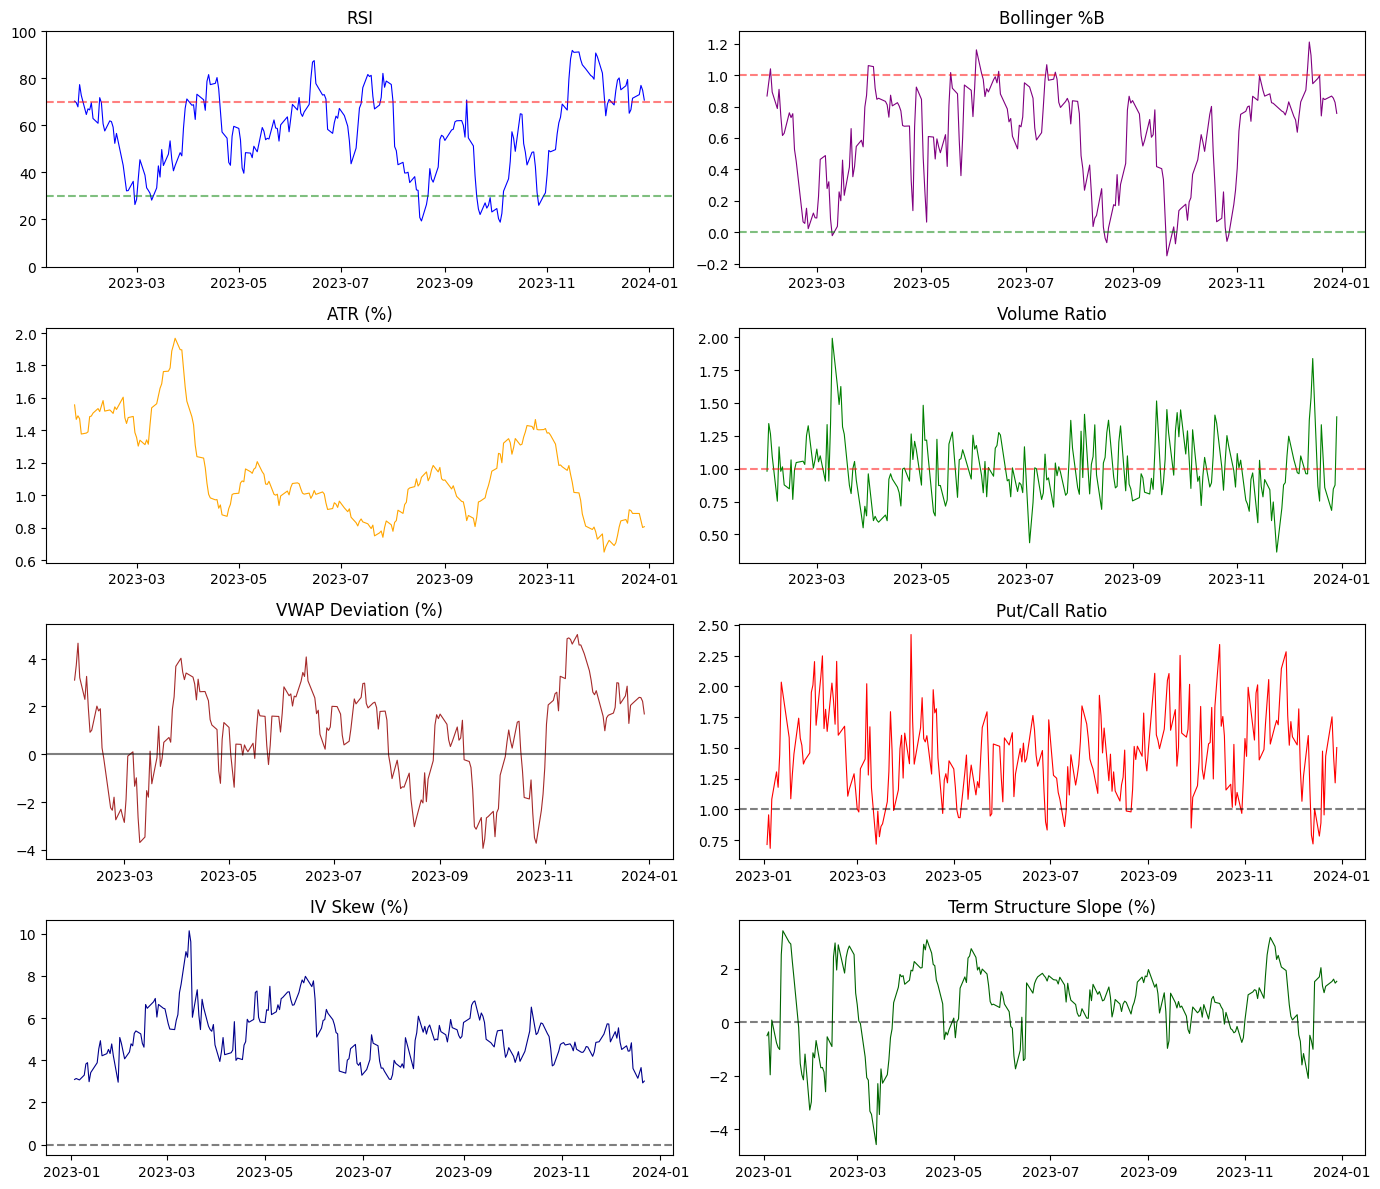

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 2, figsize=(14, 12))

# RSI
axes[0, 0].plot(all_features['rsi'], 'b-', linewidth=0.8)
axes[0, 0].axhline(70, color='r', linestyle='--', alpha=0.5)
axes[0, 0].axhline(30, color='g', linestyle='--', alpha=0.5)
axes[0, 0].set_title('RSI')
axes[0, 0].set_ylim(0, 100)

# Bollinger %B
axes[0, 1].plot(all_features['bb_pctb'], 'purple', linewidth=0.8)
axes[0, 1].axhline(1, color='r', linestyle='--', alpha=0.5)
axes[0, 1].axhline(0, color='g', linestyle='--', alpha=0.5)
axes[0, 1].set_title('Bollinger %B')

# ATR
axes[1, 0].plot(all_features['atr'] * 100, 'orange', linewidth=0.8)
axes[1, 0].set_title('ATR (%)')

# Volume Ratio
axes[1, 1].plot(all_features['volume_ratio'], 'green', linewidth=0.8)
axes[1, 1].axhline(1, color='r', linestyle='--', alpha=0.5)
axes[1, 1].set_title('Volume Ratio')

# VWAP Deviation
axes[2, 0].plot(all_features['vwap_dev'] * 100, 'brown', linewidth=0.8)
axes[2, 0].axhline(0, color='black', linestyle='-', alpha=0.5)
axes[2, 0].set_title('VWAP Deviation (%)')

# Put/Call Ratio
axes[2, 1].plot(opt_features['put_call_ratio'], 'red', linewidth=0.8)
axes[2, 1].axhline(1, color='black', linestyle='--', alpha=0.5)
axes[2, 1].set_title('Put/Call Ratio')

# IV Skew
axes[3, 0].plot(opt_features['iv_skew'] * 100, 'darkblue', linewidth=0.8)
axes[3, 0].axhline(0, color='black', linestyle='--', alpha=0.5)
axes[3, 0].set_title('IV Skew (%)')

# Term Structure
axes[3, 1].plot(opt_features['term_slope'] * 100, 'darkgreen', linewidth=0.8)
axes[3, 1].axhline(0, color='black', linestyle='--', alpha=0.5)
axes[3, 1].set_title('Term Structure Slope (%)')

plt.tight_layout()
plt.show()